## Lecture 3
The **objective** of this lecture is to introduce the manipulation of rectangular data in Pandas. There are many ways to manage data tables in Python, including the table frameworks used in DATA 8.  The concepts are important.  And, in fact, there is some value in not becoming too wedded to a particular library in the beginning.  So we will teach the concepts here, and offer practical examples in multiple frameworks.

### Sort, merge, and collapse

In [1]:
# import the libraries we will use in this lecture
import pandas
import numpy
import matplotlib.pyplot as plt

First, create a dataframe from a dictionary.  Each row in a rectangular dataframe may have a unique identifier - some variable that uniquely identifies the record.  The unique identifier could be, for example, the name of a person, a time period, or the intersection of the two.  When the unique identifier for a record (a row) represents both an individual unit (e.g., a person or a country) and a time period (e.g., a day or a year) then the dataset is called **panel dataset**.  Generate a panel dataset, which tracks individuals (indexed by `i`) over time (indexed by `t`).

In [2]:
d = {
    'id': [1, 1, 2, 2], 
    't':  [1, 2, 1, 2], 
    'x':  [5, 3, 6, 2], 
    'y':  [6, 5, 1, 4]
}

df = pandas.DataFrame(data=d)

Access certain rows or certain columns in the dataframe.

In [3]:
df["y"]
df[0:2]
df[2:3]

,id,t,x,y
2,2,1,6,1


#### Sort
Sort data by a certain variable in ascending and descending order

In [4]:
df.sort_values(by=['y'])
df.sort_values(by=['y'], ascending=False)

,id,t,x,y
0,1,1,5,6
1,1,2,3,5
3,2,2,2,4
2,2,1,6,1


#### Aggregate (group by)
Collapse, or aggregate, the data by a certain variable. That is, calculate within-group statistics.

In [5]:
df.groupby("id")[["x", "y"]].sum()
df.groupby("t")[["x", "y"]].mean()

,x,y
t,,
1,5.5,3.5
2,2.5,4.5


#### Merge
Merge will extend the *width* of the dataframe, based on the identifiers in the dataset. For example, create a *new* dataframe which would add a new variable `z` to individuals `1` and `2` for each time period `1` and `2`.  Merge dataframe with the new variable to the old dataframe.

In [6]:
dfx = pandas.DataFrame({
    'id': [1, 1, 2, 2], 
    't':  [1, 2, 1, 2], 
    'z':  [4, 3, 4, 3]
})

df.merge(dfx, on=['id', 't'], how='left')

,id,t,x,y,z
0,1,1,5,6,4
1,1,2,3,5,3
2,2,1,6,1,4
3,2,2,2,4,3


The `how` parameter in `merge()` specifies how the merge would be performed.  This parameter is not useful when every individual and time period is in both the original dataframe (on the left of the `merge` expression) and the new dataframe (on the right of the `merge` expression).  It matters, however, when not all the records are represented in either or both of the dataframes.  For example, redefine the new dataframe with only records for `id==1`:

In [7]:
dfx = pandas.DataFrame({
    'id': [1, 1], 
    't':  [1, 2], 
    'z':  [4, 3]
})

# The record identifiers for df are kept, even when not represented in dfx
df.merge(dfx, on=['id', 't'], how='left')

,id,t,x,y,z
0,1,1,5,6,4.0
1,1,2,3,5,3.0
2,2,1,6,1,NaN
3,2,2,2,4,NaN


In [8]:
# The record identifiers for dfx are kept, and only those record identifiers, 
# even not represented in df, noting that dfx contains a subset of the record 
# identifiers of df
df.merge(dfx, on=['id', 't'], how='right')

,id,t,x,y,z
0,1,1,5,6,4
1,1,2,3,5,3


In [9]:
# The union of record identifiers in df and dfx are kept.  When the record 
# identifiers in the right dataframe are a subset of those in the left 
# dataframe, then `how=left` is equivalent to `how=outer`
df.merge(dfx, on=['id', 't'], how='outer')

,id,t,x,y,z
0,1,1,5,6,4.0
1,1,2,3,5,3.0
2,2,1,6,1,NaN
3,2,2,2,4,NaN


In [10]:
# The intersection of record identifiers in df and dfx are kept.  When the record 
# identifiers in the right dataframe are a subset of those in the left 
# dataframe, then `how=right` is equivalent to `how=inner`
df.merge(dfx, on=['id', 't'], how='inner')

,id,t,x,y,z
0,1,1,5,6,4
1,1,2,3,5,3


Suppose, instead, that the record identifiers of the right dataframe are not just a subset of those in the left:

In [11]:
dfx = pandas.DataFrame({
    'id': [1, 1, 3, 3], 
    't':  [1, 2, 1, 2], 
    'z':  [4, 3, 9, 8]
})

df.merge(dfx, on=['id', 't'], how='left')

,id,t,x,y,z
0,1,1,5,6,4.0
1,1,2,3,5,3.0
2,2,1,6,1,NaN
3,2,2,2,4,NaN


In [12]:
df.merge(dfx, on=['id', 't'], how='inner')

,id,t,x,y,z
0,1,1,5,6,4
1,1,2,3,5,3


In [13]:
df.merge(dfx, on=['id', 't'], how='right')

,id,t,x,y,z
0,1,1,5.0,6.0,4
1,1,2,3.0,5.0,3
2,3,1,NaN,NaN,9
3,3,2,NaN,NaN,8


In [14]:
df.merge(dfx, on=['id', 't'], how='outer')

,id,t,x,y,z
0,1,1,5.0,6.0,4.0
1,1,2,3.0,5.0,3.0
2,2,1,6.0,1.0,NaN
3,2,2,2.0,4.0,NaN
4,3,1,NaN,NaN,9.0
5,3,2,NaN,NaN,8.0


### Application
The EJSCREEN indices are used to prioritize federal funding in order to mitigate environmental injustice. Here, we examine the rural and urban representation in the prioritization data. Does this reflect the composition of the United States?  

First, read in a dataset that associates each U.S. county with a CDC assessment of urban/suburban/rural. The counties are uniquely identified by a Federal Information Processing System (FIPS) Code. 

In [15]:
# Source: https://www.cdc.gov/nchs/data_access/urban_rural.htm#Data_Files_and_Documentation
nchs = pandas.read_excel("https://github.com/danhammer/envirods/blob/main/data/NCHSURCodes2013.xlsx?raw=true")
nchs = nchs[["FIPS code", "State Abr.", "County name", "2013 code"]]
nchs.columns = ["fips", "state", "county", "classification"]

In [16]:
# Associate each of the classifications to one of three categories, rather 
# than one of six - just to simplify our quick analysis
remap_dict = {
    1: "urban",
    2: "suburban",
    3: "suburban",
    4: "rural",
    5: "rural",
    6: "rural"
}

# replace the values of the `classification` column based on the key-value 
# pair in `remap_dict`
nchs = nchs.replace({'classification': remap_dict})

Now, read in the EJ indices and merge the dataset with the urban/suburban/rural dataset, so that each of the Census Blocks in the EJSCREEN data now has the CDC categorization.

In [17]:
ejdf = pandas.read_csv("https://raw.githubusercontent.com/danhammer/envirods/main/data/EJSCREEN_demo2.csv")
ejdf = ejdf.merge(nchs, how='left', on='fips')

In [18]:
# A dictionary to translate opaque variable names to somthing that
# is human-readable
ejvars_dict = {
    'P_LDPNT_D2': 'Lead Paint',
    'P_DSLPM_D2': 'Diesel Particulate Matter',
    'P_CANCR_D2': 'Air Toxics Cancer Risk',
    'P_RESP_D2':  'Respiratory Hazard',
    'P_PTRAF_D2': 'Traffic Proximity',
    'P_PWDIS_D2': 'Water Discharge',
    'P_PNPL_D2':  'National Priority List',
    'P_PRMP_D2':  'Risk Management Plan',
    'P_PTSDF_D2': 'Treatment Storage and Disposal',
    'P_OZONE_D2': 'Ozone Proximity',
    'P_PM25_D2':  'PM25'
}

Each of the variables in the dataset indicates the percentile where that Census Block falls in prioritization. Those census blocks with high percentiles are prioritized for federal funding.  Here, we examine the urban/suburban/rural breakdown of the population living within these high-priority Census Blocks.

In [19]:
v = 'P_LDPNT_D2'
temp_df = ejdf[ejdf[v] > 90]
temp_df = temp_df.groupby('classification').sum()['ACSTOTPOP']

# add back in the classification variable for future reference
temp_dict = dict(temp_df)
temp_dict['classification'] = v
temp_dict

{'rural': 2159353,
 'suburban': 8769330,
 'urban': 21362290,
 'classification': 'P_LDPNT_D2'}

In [20]:
# Instead of just displaying the results for one variable, collect 
# the results for all in a list.
res = []

# Note that ejvars_dict.keys() is a list of the EJ variable names
for v in ejvars_dict.keys():
    temp_df = ejdf[ejdf[v] > 90]
    temp_df = temp_df.groupby('classification').sum()['ACSTOTPOP']
    temp_dict = dict(temp_df)
    temp_dict['classification'] = v
    res.append(temp_dict)

# Create a dataframe of the results
graphing_df = pandas.DataFrame(res)
graphing_df

,rural,suburban,urban,classification
0,2159353,8769330,21362290,P_LDPNT_D2
1,358539,8593184,23329310,P_DSLPM_D2
2,2116580,11012158,19152297,P_CANCR_D2
3,2076324,10708628,19495515,P_RESP_D2
4,491038,8866869,22933011,P_PTRAF_D2
5,3829551,11166090,17275490,P_PWDIS_D2
6,1580116,10192692,20513568,P_PNPL_D2
7,2231688,11590671,18468443,P_PRMP_D2
8,426142,6697207,25167032,P_PTSDF_D2
9,2416940,11462835,18195082,P_OZONE_D2


We now have a dataframe with the total population in rural, suburban, and urban areas that would be prioritized for EJ funding for each of the 11 indicators.  Now, convert this into a percentage, noting that we can't just divide by the total population of the United States across all of these cell values due to missing values - and the fact that those missing values aren't uniformly distributed across the indicators.

In [21]:
pop_df = graphing_df[["rural", "suburban", "urban"]]

# first sum over the columns, horizontally
total_by_class = pop_df.sum(axis="columns")

# then divide, within columns, vertically
pop_df = pop_df.div(total_by_class, axis="index")

# add back the classification
pop_df["classification"] = graphing_df["classification"]

# name it appropriately
pop_df["indicators"] = pop_df.classification.replace(ejvars_dict)

pop_df

,rural,suburban,urban,classification,indicators
0,0.066872,0.271572,0.661556,P_LDPNT_D2,Lead Paint
1,0.011107,0.266199,0.722694,P_DSLPM_D2,Diesel Particulate Matter
2,0.065567,0.341134,0.593299,P_CANCR_D2,Air Toxics Cancer Risk
3,0.064321,0.331737,0.603942,P_RESP_D2,Respiratory Hazard
4,0.015207,0.274593,0.710200,P_PTRAF_D2,Traffic Proximity
5,0.118668,0.346009,0.535323,P_PWDIS_D2,Water Discharge
6,0.048941,0.315696,0.635363,P_PNPL_D2,National Priority List
7,0.069112,0.358947,0.571941,P_PRMP_D2,Risk Management Plan
8,0.013197,0.207406,0.779397,P_PTSDF_D2,Treatment Storage and Disposal
9,0.075353,0.357378,0.567269,P_OZONE_D2,Ozone Proximity


<AxesSubplot:ylabel='indicators'>

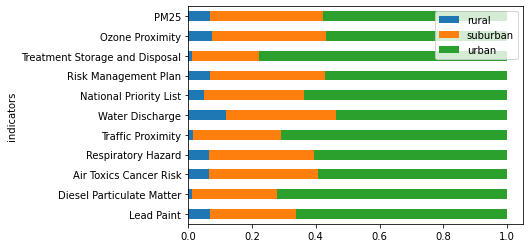

In [22]:
# Plot the results. 
pop_df = pop_df.set_index(pop_df.indicators)

pop_df.plot(
    kind="barh", 
    stacked=True
)

<AxesSubplot:ylabel='indicators'>

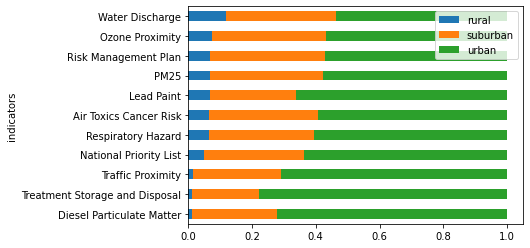

In [23]:
# replot the results, but sorting the bars by rural values
pop_df.sort_values(by=['rural']).plot(
    kind="barh", 
    stacked=True
)

Does this plot reflect the composition rest of the country?  **No.**

In [24]:
ejdf.groupby("classification").sum()["ACSTOTPOP"] / sum(ejdf["ACSTOTPOP"])

classification
rural       0.231544
suburban    0.453165
urban       0.304910
Name: ACSTOTPOP, dtype: float64

Should it?  I don't know.  But this very apparent mismatch is not being adequately addressed at the highest levels of government, as they discuss how to identify "underserved communities."